In [169]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
from matplotlib import pyplot as plt

import tnetwork as tn
from tnetwork import DCD
import tnetwork.DCD.externals

In [20]:
df = pd.read_csv("simplewiki/out.link-dynamic-simplewiki", sep=" ", comment="%", names=["source", "target", "added_removed", "timestamp"])
print(df["timestamp"].min())
df["timestamp"] -= df["timestamp"].min()
df.sort_values(by="timestamp", inplace=True)
timedelta = df["timestamp"].max() - df["timestamp"].min()





1000133972


,source,target,added_removed,timestamp
1260824,30055,30025,-1,0
1477308,12809,8225,-1,1933117
1477307,12809,614,-1,1933117
1477306,12809,5389,-1,1933117
1477305,12809,1340,-1,1933117
1477309,12809,1340,1,2206518
1477310,12809,5389,1,2206518
74817,6994,2949,1,2411288
74813,6994,6995,1,2411288
74814,6994,2943,1,2411288


In [176]:
def prune_graph(G):
    prev_shape = None
    shape = (len(G.nodes()), len(G.edges()))
    while prev_shape != shape:
        prev_shape = shape
        removed_nodes = set()
        for node in G.nodes():
            if G.out_degree(node) == 0 or G.in_degree(node) == 0:
                removed_nodes.add(node)
        G.remove_nodes_from(removed_nodes)
        shape = (len(G.nodes()), len(G.edges()))
    return G

In [172]:
def largest_componenst(G):
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    return G.subgraph(largest_cc)

In [195]:
G = nx.DiGraph()
DG = tn.DynGraphSN()

splits = 100
t = 0
for i in tqdm(range(0, df.shape[0], df.shape[0] // splits)):
    G = G.copy()
    sub_df = df.iloc[i: i + df.shape[0] // splits]
    for _, row in sub_df.iterrows():
        if row["added_removed"] > 0:
            G.add_edge(row["source"], row["target"])
        else:
            try:
                G.remove_edge(row["source"], row["target"])
            except nx.NetworkXError:
                pass
    G = prune_graph(G)
    G = largest_componenst(G)
    DG.add_snapshot(t, G)
    t += 1


100%|██████████| 101/101 [01:03<00:00,  1.58it/s]


In [198]:
snapshot = DG.snapshots(50)
snapshot.number_of_nodes(), snapshot.size()

(14431, 138415)

1250 15072
1266 15370
1291 15662
1305 15838
1317 16107


[]

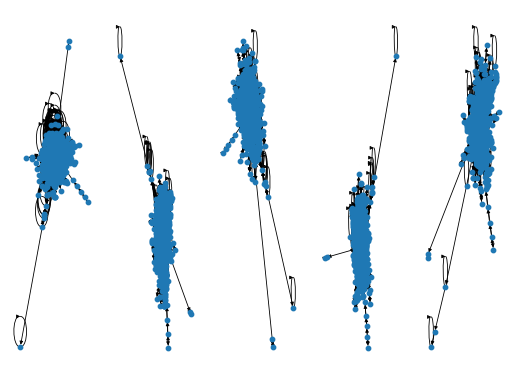

In [194]:
from_, to = 60, 65
fig, axs = plt.subplots(1, to - from_)
for i in range(from_, to):
    snapshot = DG.snapshots(i)
    print(snapshot.number_of_nodes(), snapshot.size())
    nx.draw(snapshot, pos=nx.spring_layout(snapshot), node_size=10, arrowsize=5, width=0.6, ax=axs[i - from_])
plt.plot()
# plt.savefig("wiki.png")

In [ ]:
DCD.label_smoothing(DG)
